In [1]:
import os
import argparse
import datetime
import json
import time
from tqdm import tqdm


import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Crippen

from sklearn.metrics import r2_score

In [2]:
def read_ZINC_smiles(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    smiles = [smile.strip() for smile in lines]
    mol_list = [Chem.MolFromSmiles(smile) for smile in smiles]
    logp_list = [Crippen.MolLogP(mol) for mol in mol_list]
    return smiles, logp_list, mol_list

def one_of_k_encoding(x, vocab):
    if x not in vocab:
        x = vocab[-1]
        print(f'inputs {x} is not cluded in vocab dataset. {x} is recongnized as {vocab[-1]}')
    encoded = list(map(lambda s: float(s==x), vocab))
    return encoded

def get_atom_features(mol):
    '''
    return atom features (N_atom, N_features)
    '''
    atoms = mol.GetAtoms()
    atom_feature = []

    atom_vocab = [
        'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
        'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
        'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
        'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb', 'Unk'
    ]

    for atom in atoms:
        atom_feature_tmp = one_of_k_encoding(atom.GetSymbol(), atom_vocab)
        atom_feature_tmp += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
        atom_feature_tmp += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
        atom_feature_tmp += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
        atom_feature.append(atom_feature_tmp)
    return np.array(atom_feature) # (N_atom, N_features 58)    

def power_of_adj_matrix(mol, power):
    '''
    power of adjacency matrix,
    Change all non-zero elements in adj to 1.
    '''
    
    adj = Chem.rdmolops.GetAdjacencyMatrix(mol).astype(float)
    adj += np.eye(*adj.shape)

    tmp = adj
    for i in range(power):
        tmp = np.matmul(tmp, adj)
    tmp = tmp.astype(bool).astype(float)
    # preprocessing elements convert non-zero elements to 1

    return tmp

def get_graph(smiles_list, max_atom, power=1):

    atom_feature_lists = []
    adj_list = []

    for smile in tqdm(smiles_list, desc='Convering smile_list to Graph'):
        mol = Chem.MolFromSmiles(smile)

        atom_feature_tmp = np.zeros(shape=(max_atom, 58)) # 58 = numbers of  atom_feature (ref, func get_atom_features)
        atom_feature = get_atom_features(mol)
        atom_feature_tmp[:atom_feature.shape[0], :] = atom_feature
        atom_feature_lists.append(atom_feature_tmp)

        adj_tmp = np.zeros(shape=(max_atom, max_atom))
        adj = power_of_adj_matrix(mol, power)
        adj_tmp[:adj.shape[0], :adj.shape[1]] = adj
        adj_list.append(adj_tmp)
    
    return np.array(atom_feature_lists), np.array(adj_list)

In [3]:
class GCNDataset(torch.utils.data.Dataset):

    def __init__(self, file_path, max_atom, power=1, dtype=torch.float32):

        self.smiles, self.logp_list, _ = read_ZINC_smiles(file_path)
        self.atom_feature_list, self.adj_list = get_graph(self.smiles, max_atom, power)

        self.atom_feature_list = torch.tensor(self.atom_feature_list, dtype=dtype)
        self.adj_list = torch.tensor(self.adj_list, dtype=dtype)
        self.logp_list = torch.tensor(self.logp_list, dtype=dtype)
        
    def __len__(self, ):
        return len(self.smiles)

    def __getitem__(self, i):
        return self.atom_feature_list[i], self.adj_list[i], self.logp_list[i], self.smiles[i]


In [4]:
datasets = GCNDataset('./data/ZINC.smiles', 50, 1, dtype=torch.float32)

train_size = int(len(datasets) * 0.7)
val_size = int(len(datasets) * 0.1)
test_size = len(datasets) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(datasets, lengths=[train_size, val_size, test_size])

dataset_partitions = {
    'train' : train_dataset,
    'val' : val_dataset,
    'test' : test_dataset
}

Convering smile_list to Graph: 100%|██████████| 192734/192734 [03:13<00:00, 997.96it/s] 


In [5]:
samples = next(iter(dataset_partitions['train']))
print('atom_feature_size: ', samples[0].shape)
print('adj_matrix_size  : ', samples[1].shape)
print('value of logP    : ', samples[2].item())

atom_feature_size:  torch.Size([50, 58])
adj_matrix_size  :  torch.Size([50, 50])
value of logP    :  0.7272199988365173


In [6]:
class GCNlayer(nn.Module):
    def __init__(self, in_dim, out_dim, n_atom, use_bn):
        super(GCNlayer, self).__init__()

        self.use_bn = use_bn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.kaiming_normal_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.act = nn.ReLU()

    def forward(self, features, adj):
        x = self.linear(features) # (B, atom, out_dim)
        x = torch.matmul(adj, x) # (B, atom, out_dim)

        if self.use_bn:
            x = self.bn(x)
        x = self.act(x)
        return x, adj
    
class SkipConnection(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)
        
    def forward(self, in_features, out_features):
        if in_features.shape[-1] != out_features.shape[-1]:
            in_features = self.linear(in_features)
        
        out = in_features + out_features
        return out
    

class GatedSkipConnection(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)
        self.coeff_in = nn.Linear(out_dim, out_dim)
        self.coeff_out = nn.Linear(out_dim, out_dim)

        self.sigmoid = nn.Sigmoid()

    def forward(self, in_features, out_features):

        if in_features.shape[-1] != out_features.shape[-1]:
            in_features = self.linear(in_features)
        
        z = self.geated_coefficient(in_features, out_features)
        out = torch.mul(z, out_features) + torch.mul((1.0 - z), in_features)
        return out

    def geated_coefficient(self, in_featuers, out_features):
        in_z = self.coeff_in(in_featuers)
        out_z = self.coeff_out(out_features)
        return self.sigmoid(in_z + out_z) # (B, atom, out_dim)
    

class GCNBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, sc, n_atom, use_bn=True):
        super(GCNBlock, self).__init__()

        self.layer = nn.ModuleList()
        for i in range(n_layers):
            self.layer.append(
                GCNlayer(in_dim if i == 0 else hidden_dim,
                         hidden_dim,
                         n_atom=n_atom,
                         use_bn=use_bn)
            )

        if sc == 'gsc':
            self.sc = GatedSkipConnection(in_dim, hidden_dim)
        elif sc == 'sc':
            self.sc = SkipConnection(in_dim, hidden_dim)
        elif sc == 'None':
            self.sc = 'None'    

    def forward(self, features, adj):

        x = features
        for i in range(len(self.layer)):
            x, adj = self.layer[i](x, adj)
        if self.sc != 'None':
            x = self.sc(features, x)
        return x, adj

In [7]:
class ReadOut(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ReadOut, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.kaiming_normal_(self.linear.weight)
        self.act = nn.ReLU()

    def forward(self, features):
        x = self.linear(features)
        x = self.act(x)
        x = torch.sum(x, dim=-1)
        return x # (B, n_atom)
    
class Predictor(nn.Module):
    def __init__(self, n_atom, hidden_dim, out_dim, n_layers):
        super(Predictor, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(
                nn.Linear(n_atom if i == 0 else hidden_dim,
                          hidden_dim if i != (n_layers -1) else out_dim)
            )
            
            if i != (n_layers -1):
                self.layers.append(nn.ReLU())

    def forward(self, features):
        x = features
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x # (B, out_dim)


In [8]:
class GCNNet(nn.Module):

    def __init__(self, in_dim, hidden_dim, out_dim, n_layers, n_atom, use_bn, n_block, sc):
        super(GCNNet, self).__init__()

        self.blocks = nn.ModuleList()
        for i in range(n_block):
            self.blocks.append(
                GCNBlock(in_dim if i == 0 else hidden_dim,
                         hidden_dim,
                         n_layers,
                         sc,
                         n_atom,
                         use_bn)
            )

        self.readout = ReadOut(hidden_dim, hidden_dim)
        self.predictor = Predictor(n_atom, hidden_dim, out_dim, n_layers)

    def forward(self, features, adj):

        x = features
        for i in range(len(self.blocks)):
            x, adj = self.blocks[i](x, adj)
        
        x = self.readout(x)
        x = self.predictor(x)
        return x.squeeze()
    

# inputs = torch.rand((128, 50, 58))
# adj = torch.rand((128, 50, 50))

# model = GCNNet(58, 64, 5, 3, 50, True, 3, 'gsc')
# model(inputs, adj).shape

In [9]:
def train_step(model, dataset_partition, loss_fn, optimizer, device, args):
    train_dataloader = DataLoader(dataset_partition['train'], batch_size=args.batch_size, shuffle=True, drop_last=True)

    model = model.to(device)
    train_losses = 0.0
    train_r2_score = 0.0

    model.train()
    for features, adj, labels, _ in train_dataloader:
        optimizer.zero_grad()
        features, adj, labels = features.to(device), adj.to(device), labels.to(device)
        output = model(features, adj)
        loss = loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        train_losses += loss.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        output = output.cpu().detach().numpy()

        train_r2_score += r2_score(labels, output)
    train_losses /= len(train_dataloader)
    train_r2_score /= len(train_dataloader)

    return model, train_losses, train_r2_score

def val_step(model, dataset_partition, loss_fn, device, args):
    val_dataloader = DataLoader(dataset_partition['val'], batch_size=args.batch_size, drop_last=True)

    model = model.to(device)
    val_losses = 0.0
    val_r2_score = 0.0

    model.eval()
    with torch.no_grad():
        for features, adj, labels, _ in val_dataloader:
            features, adj, labels = features.to(device), adj.to(device), labels.to(device)

            output = model(features, adj)
            loss = loss_fn(output, labels)

            val_losses += loss.cpu().detach().numpy()

            labels = labels.cpu().detach().numpy()
            output = output.cpu().detach().numpy()
        

            val_r2_score += r2_score(labels, output)
        val_losses /= len(val_dataloader)
        val_r2_score /= len(val_dataloader)
    return val_losses, val_r2_score


def test_step(model, dataset_partition, device, args):
    test_dataloader = DataLoader(dataset_partition['test'], args.batch_size, drop_last=True)

    model = model.to(device)
    test_r2_score = 0.0

    model.eval()
    with torch.no_grad():
        for features, adj, labels, _ in test_dataloader:
            features, adj, labels = features.to(device), adj.to(device), labels.to(device)

            output = model(features, adj)
            
            labels = labels.cpu().detach().numpy()
            output = output.cpu().detach().numpy()
    
            test_r2_score += r2_score(labels, output)
        test_r2_score /= len(test_dataloader)
    return test_r2_score

In [10]:
def experiment(dataset_partition, device, args):

    model = GCNNet(
        args.in_dim, args.hidden_dim, args.out_dim, args.n_layer, 50, True, args.n_block, args.sc
    )

    model = model.to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_losses = []
    train_r2_scores = []
    val_losses = []
    val_r2_scores = []

    for epoch in range(1, args.epochs + 1):
        ts = time.time()
        model, train_loss, train_r2 = train_step(model, dataset_partition, loss_fn, optimizer, device, args)
        val_loss, val_r2 = val_step(model, dataset_partition, loss_fn, device, args)
        te = time.time()

        print('Epoch: {}, LOSS(train/val) : ({:.2f}/{:.2f}), R2(train/val) : ({:.4f}/{:.4f}), TIME TOOK {:.2f}'.format(
            epoch, train_loss, val_loss, train_r2, val_r2, te-ts
        ))

        train_losses.append(train_loss)
        train_r2_scores.append(train_r2)
        val_losses.append(val_loss)
        val_r2_scores.append(val_r2)

    test_r2 = test_step(model, dataset_partition, device, args)
    print('='*10, f'TEST R2 = {test_r2:.4f}', '='*10)
    
    results = {}
    results['train_losses'] = train_losses
    results['train_r2_scores'] = train_r2_scores
    results['val_losses'] = val_losses
    results['val_r2_scores'] = val_r2_scores

    results['train_r2'] = train_r2
    results['val_r2'] = val_r2
    results['test_r2'] = test_r2
    return model, vars(args), results


In [11]:
def save_exp_results(setting, results):

    exp_name = setting['exp_name']
    dir_path = './results'
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    results.update(setting)
    file_name = f'{exp_name}_{datetime.datetime.now()}.json'
    file_path = os.path.join(dir_path, file_name)

    with open(file_path, 'w') as f:
        json.dump(results, f)

def load_exp_results(exp_name):
    dir_path = './results'
    file_list = [f for f in os.listdir(dir_path) if exp_name in f]

    list_results = []
    for file in file_list:
        if '.json' in file:
            with open(os.path.join(dir_path, file), 'r') as f:
                list_results.append(json.load(f))
    return pd.DataFrame(list_results)

In [12]:
# Experiment
# Seed Initialization
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = 'Model_skipconnection'

# Model Capacity
args.in_dim = 58
args.hidden_dim = 64
args.out_dim = 1
args.n_layer = 3
args.n_block = 2
args.sc = 'gsc'

# Training
args.batch_size = 512
args.epochs = 5

# Device
device = torch.device('mps')

# Experiment
exp_var = 'sc'
list_exp_var = ['None', 'sc', 'gsc']


for var in list_exp_var:
    setattr(args, exp_var, var)
    print(vars(args))
    model, setting, results = experiment(dataset_partitions, device, args)

    save_exp_results(setting, results)
results = load_exp_results(args.exp_name)


{'exp_name': 'Model_skipconnection', 'in_dim': 58, 'hidden_dim': 64, 'out_dim': 1, 'n_layer': 3, 'n_block': 2, 'sc': 'None', 'batch_size': 512, 'epochs': 5}
Epoch: 1, LOSS(train/val) : (0.61/0.43), R2(train/val) : (0.6578/0.7576), TIME TOOK 8.24
Epoch: 2, LOSS(train/val) : (0.24/0.21), R2(train/val) : (0.8637/0.8841), TIME TOOK 8.05
Epoch: 3, LOSS(train/val) : (0.19/0.18), R2(train/val) : (0.8925/0.8979), TIME TOOK 8.28
Epoch: 4, LOSS(train/val) : (0.17/0.17), R2(train/val) : (0.9058/0.9019), TIME TOOK 8.88
Epoch: 5, LOSS(train/val) : (0.15/0.14), R2(train/val) : (0.9156/0.9218), TIME TOOK 9.28
========== TEST R2 = 0.9116 ==========
{'exp_name': 'Model_skipconnection', 'in_dim': 58, 'hidden_dim': 64, 'out_dim': 1, 'n_layer': 3, 'n_block': 2, 'sc': 'sc', 'batch_size': 512, 'epochs': 5}
Epoch: 1, LOSS(train/val) : (0.53/0.48), R2(train/val) : (0.7030/0.7317), TIME TOOK 12.00
Epoch: 2, LOSS(train/val) : (0.19/0.15), R2(train/val) : (0.8938/0.9143), TIME TOOK 16.98
Epoch: 3, LOSS(train/val

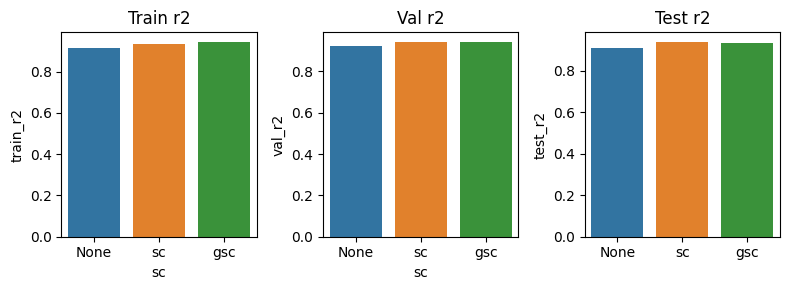

In [13]:
def plot_acc(results, var1=None, var2=None):
    fig, ax = plt.subplots(1, 3, figsize=(8, 3))

    sns.barplot(data=results, x=var1, y='train_r2', hue=var2, ax=ax[0])
    sns.barplot(data=results, x=var1, y='val_r2', hue=var2, ax=ax[1])
    sns.barplot(data=results, x=var1, y='test_r2', hue=var2, ax=ax[2])

    ax[0].set_title('Train r2')
    ax[1].set_title('Val r2')
    ax[2].set_title('Test r2')

    plt.xlabel("")
    plt.tight_layout()
    plt.show()

plot_acc(results, 'sc')

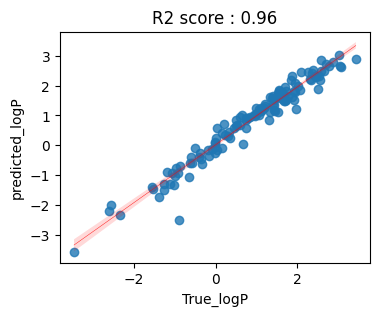

In [14]:
features, adj, labels, _ = next(iter(DataLoader(dataset_partitions['test'], batch_size=128, shuffle=True)))

model.eval()
model = model.to(device)
model, features, adj = model.to(device), features.to(device), adj.to(device)
prediction = model(features, adj)

labels = labels.cpu().detach().numpy()
prediction = prediction.cpu().detach().numpy()

plt.figure(figsize=(4, 3))
sns.regplot(x=labels, y=prediction, line_kws={'color' : 'red','lw' : 0.3 })
plt.title(f'R2 score : {r2_score(labels, prediction):.2f}')
plt.xlabel('True_logP')
plt.ylabel('predicted_logP')

plt.show();